<a href="https://colab.research.google.com/github/Pavel02021988/ML_housing_price/blob/master/Transfer_style_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачиваем изображения


In [0]:

!wget https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg  

--2020-01-14 09:32:34--  https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3170828 (3.0M) [image/jpeg]
Saving to: ‘Green_Sea_Turtle_grazing_seagrass.jpg.2’

Green_Sea_Turtle_gr 100%[===================>]   3.02M  8.07MB/s    in 0.4s    

2020-01-14 09:32:34 (8.07 MB/s) - ‘Green_Sea_Turtle_grazing_seagrass.jpg.2’ saved [3170828/3170828]

--2020-01-14 09:32:36--  https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2684586 (2.6M) [imag

Импортируем необходимые пакеты

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

Включение моментального исполнения


In [0]:
tf.enable_eager_execution()
print('Eager execution: {}'.format(tf.executing_eagerly()))

Eager execution: True


In [0]:

content_path = 'Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = 'The_Great_Wave_off_Kanagawa.jpg'

 Визуализируем ввод

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)  

Это входной контент и стиль изображения. Мы надеемся «создать» изображение с содержанием нашего содержимого изображения, но со стилем изображения стиля

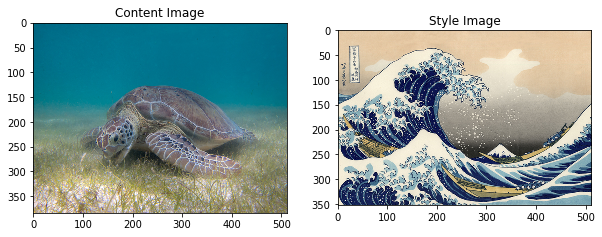

In [0]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')


plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Давайте создадим методы, которые позволят нам легко загружать и обрабатывать изображения. Мы выполняем тот же процесс предварительной обработки, который ожидается в соответствии с процессом обучения VGG. Сети VGG обучаются на изображении с каждым каналом, нормализованным mean = [103.939, 116.779, 123.68]и с каналами BGR.

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Чтобы просмотреть результаты нашей оптимизации, мы должны выполнить шаг обратной предварительной обработки. Кроме того, поскольку наше оптимизированное изображение может принимать свои значения где-то между - ∞  и  ∞ , мы должны обрезать, чтобы сохранить наши значения в диапазоне 0-255.

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # выполнить инверсию шага предварительной обработки
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Мы извлечем  промежуточные слои из нашей сети:

In [0]:
# Контентный слой
content_layers = ['block5_conv2'] 

# Слои стиля
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Мы загружаем VGG19 и вводим наш входной тензор в модель. Это позволит нам извлекать карты функций (а затем представления контента и стилей) контента, стиля и сгенерированных изображений.

In [0]:
def get_model():
  """ Создаем модель с доступом к промежуточным слоям """
  # Загружаем предварительно обученную модель VGG
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Получаем выходные слои соответсвующие слоям стиля и контента
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # строим модель 
  return models.Model(vgg.input, model_outputs)

мы создали модель, которая будет брать входное изображение и выводить промежуточные слои содержимого и стиля

Определение и создание функций потерь (контент и стилистические расстояния)

Контент loss


In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

Стиль loss

In [0]:
def gram_matrix(input_tensor):
  # Сначала создаем каналы изображений 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Ожидается два изображения размера h, w, c"""
  # высота ширина количество фильтров каждого слоя
  # масштабируем потреи в слое по размеру карты и количеству фильтров
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

Применяем Style transfer к нашим изображениям 

Мы определим небольшую вспомогательную функцию, которая будет загружать наш контент и изображение стиля, передавать их через нашу сеть, которая затем будет выводить представления функций контента и стиля из нашей модели.

In [0]:
def get_feature_representations(model, content_path, style_path):
  """
Вспомогательная функция для вычисления нашего контента и представления стилей.

  Эта функция просто загружает и обрабатывает как контент, так и стиль
  изображения с их пути. Затем он будет кормить их через сеть, чтобы получить
  выходы промежуточных слоев.
  
  Аргументы:
    модель: модель, которую мы используем.
    content_path: путь к изображению содержимого.
    style_path: путь к изображению стиля
    
  Возвращает:
    возвращает функции стиля и функции контента
  """
  # Загружаем наши изображения
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # пакетное вычисление содержимого и стилей
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Получаем представления стиля и содержания от нашей модели  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

Вычисление потерь и градиентов

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """Эта функция вычислит общую потерю.
  
  Аргументы:
    модель: модель, которая даст нам доступ к промежуточным слоям
    loss_weights: вес каждого вклада каждой функции потерь.
      (вес стиля, вес содержимого и общий вес отклонения)
    init_image: наше начальное базовое изображение. Это изображение - то, что мы обновляем
      наш процесс оптимизации. Мы применяем градиенты к потерям
      в расчете на это изображение.
    gram_style_features: предварительно вычисленные грамм-матрицы, соответствующие
      определенные стили слоя интересов.
    content_features: предварительно вычисленные выходные данные из определенных слоев содержимого
      интерес.
      
  Возвращает:
    возвращает общую потерю, потерю стиля, потерю контента и общую вариационную потерю
  """
  style_weight, content_weight = loss_weights
  
  # Пропустите наш начальный образ через нашу модель. Это даст нам содержание и
  # стилевые представления на желаемых слоях. Так как мы используем моментальное исполнение
  # наша модель вызывается так же, как и любая другая функция!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Накопить потери стиля от всех слоев
  # Здесь мы одинаково взвешиваем каждый вклад каждого слоя потерь
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # накапливать потери контента со всех слоев
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # получить полную потерю
  loss = style_score + content_score 
  return loss, style_score, content_score

Вычисляем градиент

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # вычислить градиенты по входному изображению
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

Цикл оптимизации

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Получить представления стиля и содержимого (из указанных нами промежуточных слоев) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Установить начальное изображение
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Создаем наш оптимизатор
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # для отображения промежуточных изображений
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Храним наш лучший результат
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # для отображения
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Обновите лучшие потери и лучшие изображения от полной потери. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      #Используйте метод .numpy (), чтобы получить конкретный массив numpy
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss

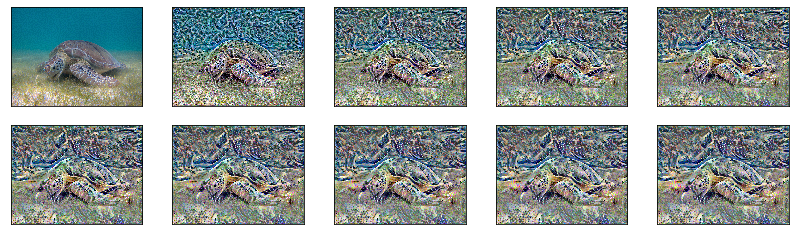

In [0]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

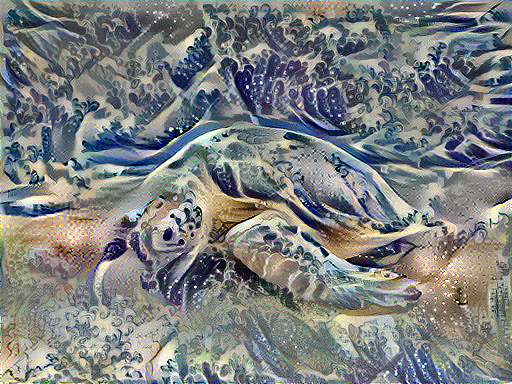

In [0]:
Image.fromarray(best)

Для загрузки изображения из Colab раскомментируйте следующий код:

In [0]:
#from google.colab import files
#files.download('wave_turtle.png')

Визуализируйте результаты

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

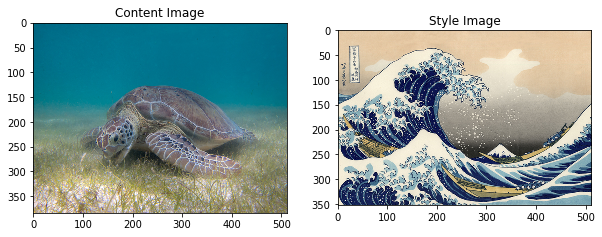

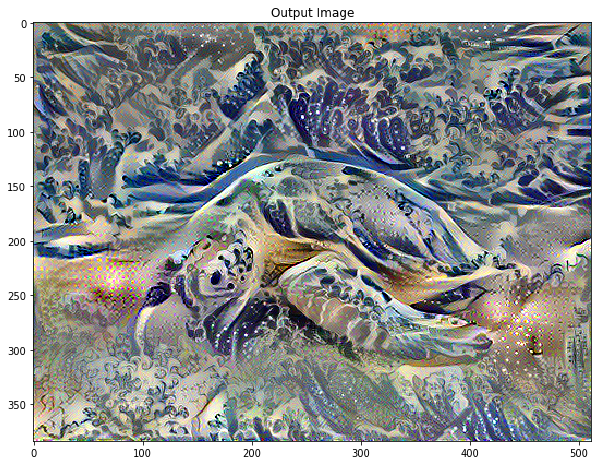

In [0]:
show_results(best, content_path, style_path)

Starry night + Tuebingen
In [0]:
best_starry_night, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg',
                                                  '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
In [0]:
show_results(best_starry_night, '/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
Pillars of Creation + Tuebingen
In [0]:
best_poc_tubingen, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg', 
                                                  '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')
In [0]:
show_results(best_poc_tubingen, 
             '/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [0]:
from google.colab import files

In [0]:
files.upload()

Saving ita.jpg to ita.jpg


{'ita.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 85\n\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc0\x00\x11\x08\x01\xc2\x02X\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06

In [0]:
!ls


Green_Sea_Turtle_grazing_seagrass.jpg	 The_Great_Wave_off_Kanagawa.jpg
Green_Sea_Turtle_grazing_seagrass.jpg.1  The_Great_Wave_off_Kanagawa.jpg.1
Green_Sea_Turtle_grazing_seagrass.jpg.2  The_Great_Wave_off_Kanagawa.jpg.2
ita.jpg					 vangog.jpg
sample_data


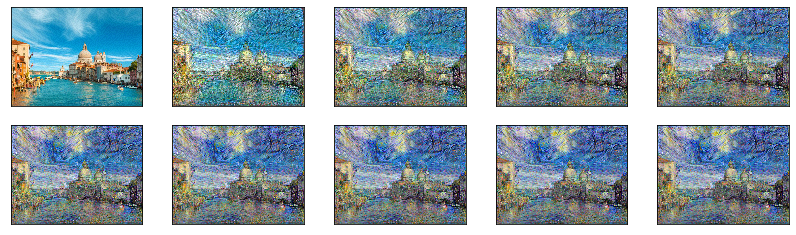

In [0]:
italiya, best_loss = run_style_transfer('ita.jpg', 'vangog.jpg')

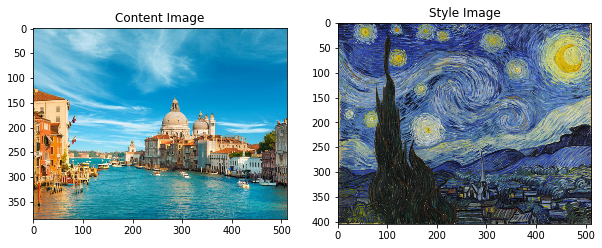

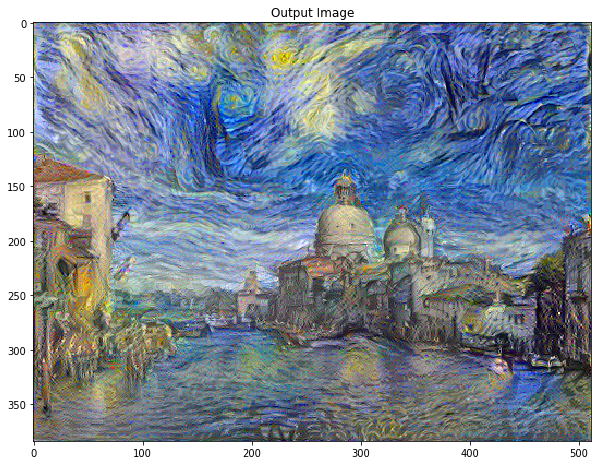

In [0]:
show_results(italiya, 'ita.jpg', 'vangog.jpg')